In [34]:
# Import Dependencies
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import col, explode, when, sum, size

# Initialize Spark Session
spark = SparkSession.builder.appName("BookRatingDataCleaning").getOrCreate()

In [35]:
# Read in data
df = spark.read.csv('Resources/panda_df/books_cleaned_sample2.csv', header=True)
df.show()

+-------------+--------------+--------+--------------------+---------+----------------+-------------+------------------+-------------+-------------+---------------------+
|       isbn13|average_rating| book_id|              format|num_pages|publication_year|ratings_count|text_reviews_count|to_read_count|series_binary|author_average_rating|
+-------------+--------------+--------+--------------------+---------+----------------+-------------+------------------+-------------+-------------+---------------------+
|0025986347017|          4.07|  609181|           Paperback|      212|            1973|           12|                 2|         12.0|            0|                 3.74|
| 222010904671|          3.96|28362852|           Paperback|      316|            2012|            6|                 4|       1993.0|            1|                 3.88|
|2940152596472|           4.0|29425575|                Nook|      221|            2016|            2|                 2|        326.0|           

In [36]:
df.printSchema()

root
 |-- isbn13: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- format: string (nullable = true)
 |-- num_pages: string (nullable = true)
 |-- publication_year: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- text_reviews_count: string (nullable = true)
 |-- to_read_count: string (nullable = true)
 |-- series_binary: string (nullable = true)
 |-- author_average_rating: string (nullable = true)



In [37]:
df.count()

59916

In [38]:
# Path to your .json.gz file
file_path = "Resources/data/goodreads_book_genres_initial.json.gz"

# Read the compressed JSON file into a DataFrame
genres_df = spark.read.json(file_path)

# Show the first few rows to verify
genres_df.show()

+--------+--------------------+
| book_id|              genres|
+--------+--------------------+
| 5333265|{NULL, NULL, NULL...|
| 1333909|{NULL, NULL, NULL...|
| 7327624|{NULL, NULL, 31, ...|
| 6066819|{NULL, NULL, NULL...|
|  287140|{NULL, NULL, NULL...|
|  287141|{6, NULL, 1, 1, 9...|
|  378460|{NULL, NULL, NULL...|
| 6066812|{16, NULL, 32, 7,...|
|34883016|{NULL, NULL, NULL...|
|  287149|{NULL, NULL, NULL...|
| 6066814|{NULL, NULL, NULL...|
|33394837|{NULL, NULL, 11, ...|
|   89371|{3, NULL, NULL, 3...|
|28575155|{NULL, NULL, NULL...|
|   89373|{NULL, NULL, NULL...|
|   89375|{NULL, 6, NULL, 1...|
|   89376|{NULL, NULL, NULL...|
|   89377|{190, NULL, NULL,...|
|   89378|{109, NULL, NULL,...|
|21401188|{NULL, NULL, 1, 7...|
+--------+--------------------+
only showing top 20 rows



In [39]:
genres_df.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- children: long (nullable = true)
 |    |-- comics, graphic: long (nullable = true)
 |    |-- fantasy, paranormal: long (nullable = true)
 |    |-- fiction: long (nullable = true)
 |    |-- history, historical fiction, biography: long (nullable = true)
 |    |-- mystery, thriller, crime: long (nullable = true)
 |    |-- non-fiction: long (nullable = true)
 |    |-- poetry: long (nullable = true)
 |    |-- romance: long (nullable = true)
 |    |-- young-adult: long (nullable = true)



In [40]:
# Extract the fields from the "genres" column
genres_df = genres_df.select(
    "book_id",
    col("genres.children"),
    col("genres.comics, graphic"),
    col("genres.fantasy, paranormal"),
    col("genres.fiction"),
    col("genres.history, historical fiction, biography"),
    col("genres.mystery, thriller, crime"),
    col("genres.non-fiction"),
    col("genres.poetry"),
    col("genres.romance"),
    col("genres.young-adult")
)

genres_df.show()

+--------+--------+---------------+-------------------+-------+--------------------------------------+------------------------+-----------+------+-------+-----------+
| book_id|children|comics, graphic|fantasy, paranormal|fiction|history, historical fiction, biography|mystery, thriller, crime|non-fiction|poetry|romance|young-adult|
+--------+--------+---------------+-------------------+-------+--------------------------------------+------------------------+-----------+------+-------+-----------+
| 5333265|    NULL|           NULL|               NULL|   NULL|                                     1|                    NULL|       NULL|  NULL|   NULL|       NULL|
| 1333909|    NULL|           NULL|               NULL|    219|                                     5|                    NULL|       NULL|  NULL|   NULL|       NULL|
| 7327624|    NULL|           NULL|                 31|      8|                                  NULL|                       1|       NULL|     1|   NULL|       NULL

In [41]:
# Change values to 1 or 0
genre_columns = ['children', 'comics, graphic', 'fantasy, paranormal', 'fiction', 
                'history, historical fiction, biography', 'mystery, thriller, crime', 
                'non-fiction', 'poetry', 'romance', 'young-adult']

for col_name in genre_columns:
    genres_df = genres_df.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(1))

genres_df.show()

+--------+--------+---------------+-------------------+-------+--------------------------------------+------------------------+-----------+------+-------+-----------+
| book_id|children|comics, graphic|fantasy, paranormal|fiction|history, historical fiction, biography|mystery, thriller, crime|non-fiction|poetry|romance|young-adult|
+--------+--------+---------------+-------------------+-------+--------------------------------------+------------------------+-----------+------+-------+-----------+
| 5333265|       0|              0|                  0|      0|                                     1|                       0|          0|     0|      0|          0|
| 1333909|       0|              0|                  0|      1|                                     1|                       0|          0|     0|      0|          0|
| 7327624|       0|              0|                  1|      1|                                     0|                       1|          0|     1|      0|          0

In [42]:
df = df.join(genres_df, on='book_id', how='left')
df.show()

+--------+-------------+--------------+---------+---------+----------------+-------------+------------------+-------------+-------------+---------------------+--------+---------------+-------------------+-------+--------------------------------------+------------------------+-----------+------+-------+-----------+
| book_id|       isbn13|average_rating|   format|num_pages|publication_year|ratings_count|text_reviews_count|to_read_count|series_binary|author_average_rating|children|comics, graphic|fantasy, paranormal|fiction|history, historical fiction, biography|mystery, thriller, crime|non-fiction|poetry|romance|young-adult|
+--------+-------------+--------------+---------+---------+----------------+-------------+------------------+-------------+-------------+---------------------+--------+---------------+-------------------+-------+--------------------------------------+------------------------+-----------+------+-------+-----------+
|12956808|9780007326976|           3.3|Paperback|   

In [43]:
df.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+---------------------+-------------------+-------------------+-------------------+-------------------+--------------------------------------+------------------------+-------------------+-------------------+-------------------+-------------------+
|summary|             book_id|              isbn13|    average_rating|              format|         num_pages|  publication_year|    ratings_count|text_reviews_count|     to_read_count|      series_binary|author_average_rating|           children|    comics, graphic|fantasy, paranormal|            fiction|history, historical fiction, biography|mystery, thriller, crime|        non-fiction|             poetry|            romance|        young-adult|
+-------+--------------------+--------------------+------------------+--------------------+-----

In [44]:
# Change dataframe to pandas dataframe
books_df = df.toPandas()
books_df.head()

,book_id,isbn13,average_rating,format,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,...,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
0,10002442,9781847326553,3.56,Paperback,288,2010,2,1,9.0,0,...,0,0,0,0,0,0,1,0,0,0
1,10002468,9780385752114,4.36,Hardcover,208,2011,37,2,23.0,1,...,1,0,0,1,0,0,0,0,0,0
2,10031880,9780375897276,3.6,ebook,352,2011,5,1,2142.0,1,...,1,0,1,1,1,0,0,0,1,1
3,1003902,9780441149247,3.77,Mass Market Paperback,185,1989,397,6,142.0,1,...,0,1,1,1,1,0,0,0,0,1
4,10041117,9788845916328,3.76,Paperback,136,2001,98,5,8360.0,0,...,0,0,0,1,1,0,0,0,1,0


In [45]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59916 entries, 0 to 59915
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   book_id                                 59916 non-null  object
 1   isbn13                                  59916 non-null  object
 2   average_rating                          59916 non-null  object
 3   format                                  59916 non-null  object
 4   num_pages                               59916 non-null  object
 5   publication_year                        59916 non-null  object
 6   ratings_count                           59916 non-null  object
 7   text_reviews_count                      59916 non-null  object
 8   to_read_count                           59245 non-null  object
 9   series_binary                           59916 non-null  object
 10  author_average_rating                   59916 non-null  object
 11  ch

In [46]:
# Check for null values
books_df.value_counts().isnull().sum()

0

In [53]:
# Change data types
# Convert columns to numeric, coercing errors to NaN
books_df['num_pages'] = pd.to_numeric(books_df['num_pages'], errors='coerce')
books_df['publication_year'] = pd.to_numeric(books_df['publication_year'], errors='coerce')
books_df['ratings_count'] = pd.to_numeric(books_df['ratings_count'], errors='coerce')
books_df['text_reviews_count'] = pd.to_numeric(books_df['text_reviews_count'], errors='coerce')
books_df['to_read_count'] = pd.to_numeric(books_df['to_read_count'], errors='coerce')
books_df['series_binary'] = pd.to_numeric(books_df['series_binary'], errors='coerce')

# Drop rows with NaN values in these columns
books_df = books_df.dropna(subset=['num_pages', 'publication_year', 'ratings_count', 'text_reviews_count', 'to_read_count', 'series_binary'])

# Convert columns to integer
books_df = books_df.astype({'num_pages': 'int32', 'publication_year': 'int32', 'ratings_count': 'int32', 'text_reviews_count': 'int32', 'to_read_count': 'int32', 'series_binary': 'int32'})

clean_df = books_df.astype({'average_rating': 'float32', 'author_average_rating': 'float32'})

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59245 entries, 0 to 59915
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   book_id                                 59245 non-null  object 
 1   isbn13                                  59245 non-null  object 
 2   average_rating                          59245 non-null  float32
 3   format                                  59245 non-null  object 
 4   num_pages                               59245 non-null  int32  
 5   publication_year                        59245 non-null  int32  
 6   ratings_count                           59245 non-null  int32  
 7   text_reviews_count                      59245 non-null  int32  
 8   to_read_count                           59245 non-null  int32  
 9   series_binary                           59245 non-null  int32  
 10  author_average_rating                   59245 non-null  fl

In [54]:
clean_df.describe()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
count,59245.000000,59245.000000,59245.000000,5.924500e+04,59245.000000,59245.000000,59245.000000,59245.000000,59245.000000,59245.000000,59245.000000,59245.000000,59245.00000,59245.000000,59245.000000,59245.000000,59245.000000,59245.000000
mean,3.851638,267.216558,2008.235041,6.112884e+02,37.535319,3875.793451,0.300599,3.884006,0.141582,0.084463,0.227479,0.567609,0.32877,0.229792,0.282370,0.045489,0.248223,0.172335
std,0.484591,182.319107,262.590333,1.834827e+04,462.921812,28333.222839,0.458522,0.343857,0.348623,0.278083,0.419208,0.495412,0.46977,0.420702,0.450156,0.208376,0.431986,0.377675
min,0.000000,0.000000,5.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.620000,160.000000,2005.000000,8.000000e+00,2.000000,18.000000,0.000000,3.720000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.890000,255.000000,2010.000000,2.600000e+01,5.000000,104.000000,0.000000,3.900000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.120000,351.000000,2014.000000,9.300000e+01,14.000000,649.000000,1.000000,4.070000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,8784.000000,65535.000000,3.255518e+06,59827.000000,835383.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


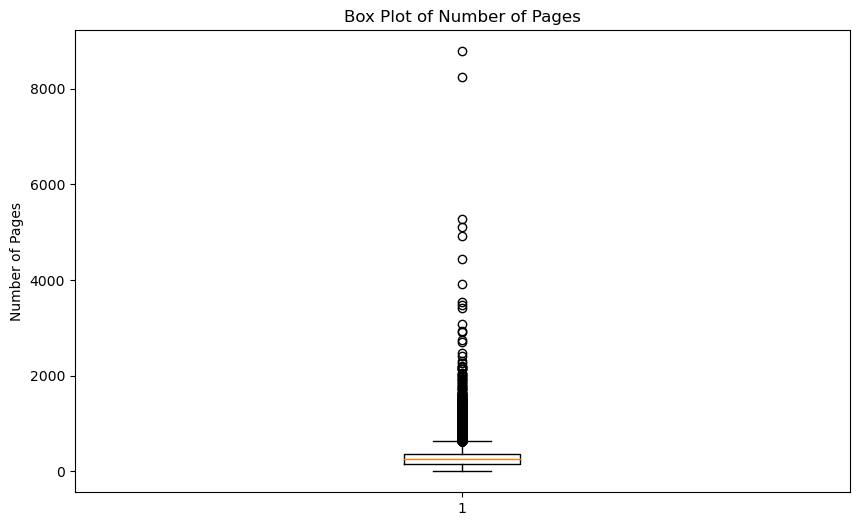

In [55]:
import matplotlib.pyplot as plt


# Create a box plot for the 'num_pages' column
plt.figure(figsize=(10, 6))
plt.boxplot(clean_df['num_pages'])  
plt.title('Box Plot of Number of Pages')
plt.ylabel('Number of Pages')

# Display the plot
plt.show()


In [56]:
# Filter out outliers
clean_df = clean_df.loc[clean_df['num_pages'] <= 1500]
clean_df.describe()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
count,59176.000000,59176.000000,59176.000000,5.917600e+04,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000,59176.000000
mean,3.851025,264.749527,2008.236329,6.114647e+02,37.560193,3871.648236,0.300612,3.883727,0.141645,0.084511,0.227373,0.567646,0.328714,0.229890,0.282226,0.045356,0.248226,0.172435
std,0.484382,160.842274,262.743264,1.835890e+04,463.188832,28317.309172,0.458528,0.343858,0.348689,0.278154,0.419139,0.495407,0.469750,0.420766,0.450087,0.208086,0.431987,0.377761
min,0.000000,0.000000,5.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.620000,160.000000,2005.000000,8.000000e+00,2.000000,18.000000,0.000000,3.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.890000,254.000000,2010.000000,2.600000e+01,5.000000,104.000000,0.000000,3.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.120000,350.000000,2014.000000,9.300000e+01,14.000000,648.250000,1.000000,4.070000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,1498.000000,65535.000000,3.255518e+06,59827.000000,835383.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


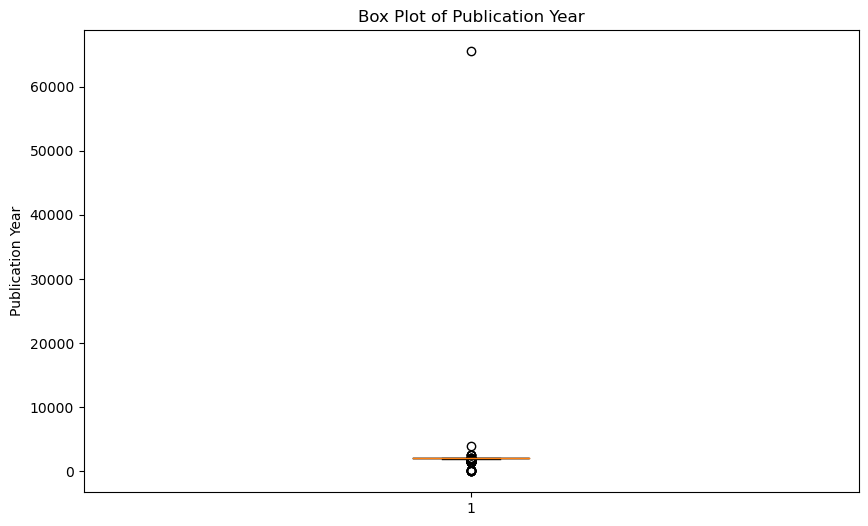

In [57]:
# Create a box plot for the 'publication_year' column
plt.figure(figsize=(10, 6))
plt.boxplot(clean_df['publication_year'])
plt.title('Box Plot of Publication Year')
plt.ylabel('Publication Year')

# Display the plot
plt.show()

In [58]:
# Filter out outliers
clean_df = clean_df.loc[clean_df['publication_year'] > 1900 ]
clean_df = clean_df.loc[clean_df['publication_year'] < 2023 ]
clean_df.describe()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
count,59138.000000,59138.000000,59138.000000,5.913800e+04,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000,59138.000000
mean,3.851121,264.755707,2007.555125,6.118509e+02,37.582248,3869.253441,0.300771,3.883814,0.141686,0.084565,0.227417,0.567740,0.328790,0.229971,0.282306,0.045352,0.248368,0.172478
std,0.484124,160.858642,9.126810,1.836479e+04,463.336802,28313.666633,0.458597,0.343771,0.348730,0.278236,0.419168,0.495394,0.469778,0.420817,0.450125,0.208076,0.432070,0.377799
min,0.000000,0.000000,1912.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.620000,160.000000,2005.000000,8.000000e+00,2.000000,18.000000,0.000000,3.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.890000,254.000000,2010.000000,2.600000e+01,5.000000,104.000000,0.000000,3.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.120000,350.000000,2014.000000,9.300000e+01,14.000000,649.000000,1.000000,4.070000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,1498.000000,2020.000000,3.255518e+06,59827.000000,835383.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,book_id,isbn13,average_rating,format,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,...,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
0,10002442,9781847326553,3.56,Paperback,288,2010,2,1,9,0,...,0,0,0,0,0,0,1,0,0,0
3,1003902,9780441149247,3.77,Mass Market Paperback,185,1989,397,6,142,1,...,0,1,1,1,1,0,0,0,0,1
4,10041117,9788845916328,3.76,Paperback,136,2001,98,5,8360,0,...,0,0,0,1,1,0,0,0,1,0
5,1004622,9781572704145,4.07,Audio CD,420,2004,17,4,74,1,...,0,0,0,1,1,1,0,0,0,0
6,1004734,9780451516695,3.45,Paperback,451,1962,32,4,41958,0,...,0,0,1,1,1,1,0,0,0,0


In [60]:
# Drop unnecessary columns
clean_df = clean_df.drop(columns=['book_id', 'isbn13'])
clean_df.head()

,average_rating,format,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
0,3.56,Paperback,288,2010,2,1,9,0,3.735,0,0,0,0,0,0,1,0,0,0
1,4.36,Hardcover,208,2011,37,2,23,1,4.195,1,0,0,1,0,0,0,0,0,0
2,3.60,ebook,352,2011,5,1,2142,1,3.960,1,0,1,1,1,0,0,0,1,1
3,3.77,Mass Market Paperback,185,1989,397,6,142,1,3.800,0,1,1,1,1,0,0,0,0,1
4,3.76,Paperback,136,2001,98,5,8360,0,3.845,0,0,0,1,1,0,0,0,1,0


In [61]:
clean_df['format'].value_counts()

Paperback                36348
Hardcover                14487
ebook                     4724
Mass Market Paperback     1471
Audio CD                   595
                         ...  
CD Audio                     1
Paper &amp; Ebook            1
Paperback and eBook          1
Paperback/Ebook              1
Audio Play                   1
Name: format, Length: 148, dtype: int64

In [62]:
# Change unpoupular formats to 'other'
clean_df.loc[(clean_df['format'] != 'Paperback') & (clean_df['format'] != 'Hardcover') & (clean_df['format'] != 'ebook'), 'format'] = 'other'
clean_df['format'].value_counts()

Paperback    36348
Hardcover    14487
ebook         4724
other         3579
Name: format, dtype: int64

In [63]:
# Export dataframe to csv
clean_df.to_csv('Resources/panda_df/books_cleaned_sample3.csv', index=False)